<>:97: SyntaxWarning: invalid escape sequence '\D'
<>:97: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Matilde\AppData\Local\Temp\ipykernel_5324\2796713602.py:97: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel(f'$\Delta$E')


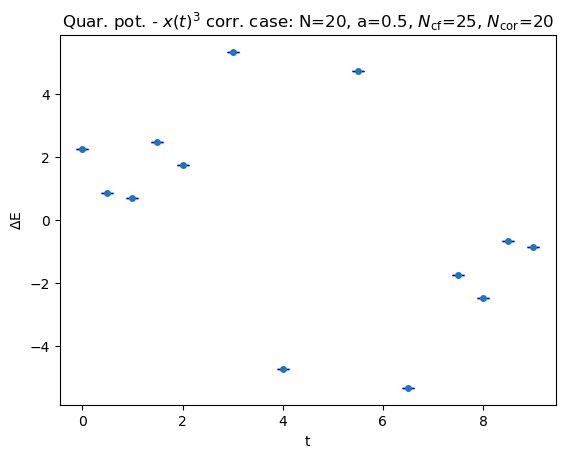

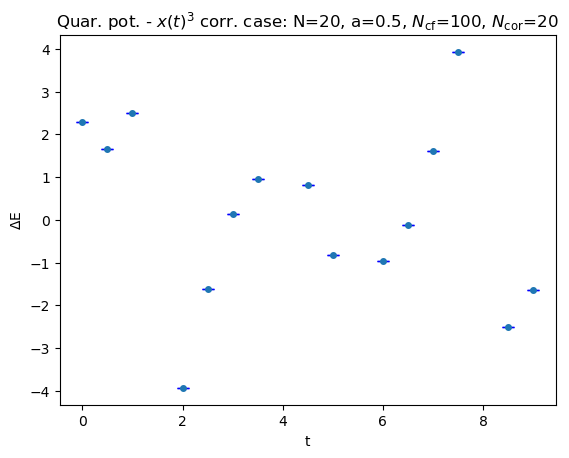

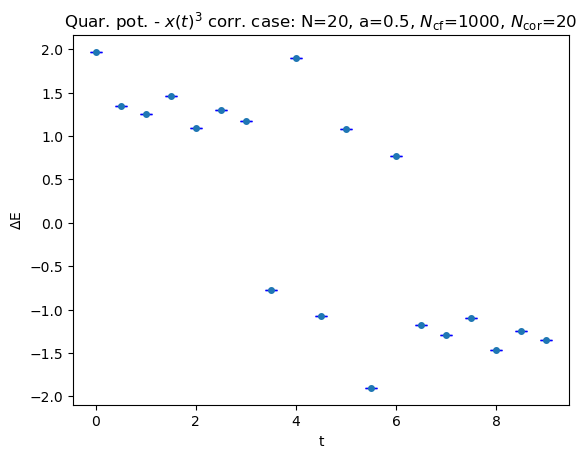

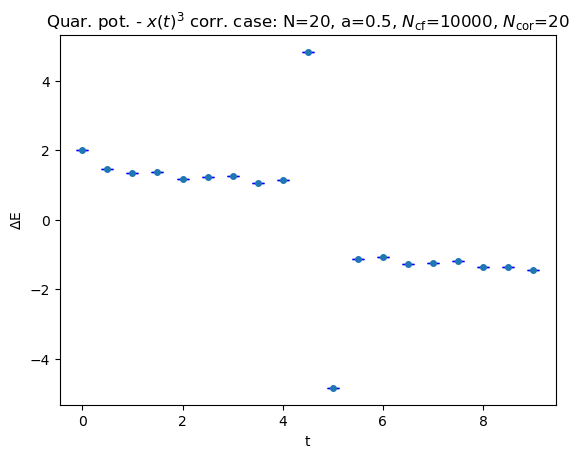

In [6]:
#Quartic potential case - correlator with cubic power - evaluation of deltaE=E_1 - E_0 - not reliable errors, datas need to be binned and bootstraped (done in ex. 4)
import vegas 
from tqdm.notebook import tqdm
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

eps=1.4
N=20
N_cor=20
N_cfv=[25,100,1000,10000]
a=0.5

#function which updates each site of an initial path in order to get a new one (Metropolis algorithm)
@njit
def update(x):
    for j in range(N):
        #saving original value and compute the action 
        old_x = x[j]           
        old_Sj = S(j,x)
        #update the x[j] using a uniformly distributed probability 
        x[j] += np.random.uniform(-eps,eps)     
        #compute the difference between the old and new action
        dS = S(j,x) - old_Sj 
        if dS>0 and np.exp(-dS)<np.random.uniform(0,1): #condition to restore the old value
            x[j] = old_x 

@njit
def S(j,x): #action
    #next and previous site by taking into account the periodicity xN=x0
    jp = (j+1)%N 
    jm = (j-1)%N 
    return a*V(x[j]) + x[j]*(x[j]-x[jp]-x[jm])/a

@njit
def V(x):#potential
    return (x**4)/2

@njit
def compute_G(x,n): #computes G(t) for a given path x and a fixed n
    g = 0
    for j in range(0,N):
        g += (x[j]**3)*(x[(j+n)%N]**3)
    return g/N

@njit
def MCaverage(x,G): #thermalize and erase correlations
    for j in range(0,N): 
        x[j] = 0 #initialization of the path as all zeros
    for j in range(10*N_cor): #thermalization since the path with all zero is atypical
        update(x)
    for alpha in range(len(G)): #Number of random path the Metropolis algorithm is generating
        for j in range(N_cor): #erasing correlations
            update(x)
        for n in range(0,N):
            G[alpha][n] = compute_G(x,n) #filling the G with the computed G(t) of the path x(alpha) with n from 0 to N
    return G

@njit
def average(G):
    sum = np.sum(G, axis=0)
    avg_G = sum/len(G)
    return avg_G

@njit
def stdDev(G):
    sdev = np.abs(average(G**2)-average(G)**2)**0.5
    return sdev
    
@njit
def deltaE(avg_G):
    delta_E=np.zeros(N-1)
    for j in range(N-1):
        delta_E[j]=np.log(avg_G[j]/avg_G[j+1])
    return delta_E/a

@njit
def analysis_deltaE(G,nbstrap=100): # Delta E + errors
    E = np.zeros((nbstrap,N-1))
    for i in range(nbstrap): # bs copies of deltaE
        g_avg=average(G)
        E[i]=deltaE(g_avg)
    sdevE = stdDev(E) # spread of deltaE’s
    avgE=average(E)
    return avgE,sdevE

if __name__ == "__main__": 
    for N_cf in N_cfv:
        G=np.zeros((N_cf, N))
        x=np.zeros(N)
        G=MCaverage(x,G)
        avgE,sdevE=analysis_deltaE(G,nbstrap=100)
        t = [a*q for q in range(len(avgE))]
        plt.errorbar(t, avgE, yerr=sdevE, fmt="o",label='computed',ecolor="blue",elinewidth=0.8,capsize=4, markersize=4)
        plt.scatter(t, avgE,c="black",marker='o', s=7)
        plt.xlabel('t')
        plt.ylabel(f'$\Delta$E')
        plt.title(f'Quar. pot. - '+ r'$x(t)^3$'+f' corr. case: N={N}, a={a}, ' + r'$N_{\text{cf}}$='+f'{N_cf}, '+ r'$N_{\text{cor}}$='+f'{N_cor}')
        #plt.axis([-0.1 , 3.2,-2,4])
        #plt.savefig(f'QuarPot1_{N_cf}')
        plt.show()